In [17]:
import torch

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from model import DenoisingDiffusionNet,extract
from DenoisingNet import UNetModel
from sam import SAM


In [2]:
# preprocess = transforms.Compose([
#     transforms.ToTensor(),
# ])
# trainset = CIFAR100(root='./cifar100',download=True,transform=preprocess)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,shuffle=True)

Files already downloaded and verified


In [4]:
device = torch.device("cuda")
states = torch.load(
    "cifar10_uncond_50M_500K.pt",
    map_location=device,
)

In [15]:
denoise_model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=6,
    num_res_blocks=3,
    attention_resolutions=(2,4),
    dropout=0.3,
    channel_mult=(1, 2, 2, 2),
    num_classes=None,
    use_checkpoint=False,
    num_heads=4,
    num_heads_upsample=-1,
    use_scale_shift_norm=True,
)
denoise_model.load_state_dict(states)
denoise_model = denoise_model.cuda()
denoise_model.eval()


UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.3, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_conne

In [ ]:
torch.split()

In [12]:

model = DenoisingDiffusionNet(1000,denoise_model)
model = model.cuda()
model.eval()

DenoisingDiffusionNet(
  (denoise_model): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=0.3, inplace=False)
            (3): Conv2

In [13]:
img = model.sample(device)

RuntimeError: The size of tensor a (3) must match the size of tensor b (6) at non-singleton dimension 1

In [41]:
with torch.no_grad():
    x = torch.randn(1,3,32,32,device=device)
    seq = range(0, model.num_timesteps, 1)

    n = 1
    seq_next = [-1] + list(seq[:-1])
    x0_preds = []
    xs = [x]
    for i, j in zip(reversed(seq), reversed(seq_next)):
        t = (torch.ones(n) * i).long().to(device)
        next_t = (torch.ones(n) * j).long().to(device)

        xt = xs[-1].to(device)
        et = model.denoise_model(xt, t)
        et = torch.split(et, 3, dim=1)[0]

        x0_t =  extract(1.0 / model.sqrt_alphas_bar, t, xt.shape) * xt - \
                extract(model.sqrt_recip_minus_one_alphas_bar, t, xt.shape) * et        
        x0_preds.append(x0_t.to('cpu'))


        xt_next = extract(model.alphas_bar_previous.sqrt(), t, xt.shape) * x0_t + \
                extract(model.coef2, t, xt.shape) * et + \
                extract(model.coef1, t, xt.shape) * torch.randn_like(x)

        xs.append(xt_next.to('cpu'))

In [42]:
xs[-1][0].shape

torch.Size([3, 32, 32])

In [43]:
xs[-1][0]

tensor([[[-0.0323, -0.0823, -0.0693,  ..., -0.1239, -0.1441, -0.1839],
         [-0.1353, -0.1763, -0.1289,  ..., -0.1185, -0.1980, -0.2528],
         [-0.1315, -0.1969, -0.2170,  ..., -0.2240, -0.2706, -0.3059],
         ...,
         [-0.0181,  0.0750,  0.1432,  ..., -0.1917, -0.2070, -0.2413],
         [ 0.0942, -0.1259, -0.1360,  ..., -0.2170, -0.2059, -0.2627],
         [ 0.2791, -0.2413, -0.3032,  ..., -0.2185, -0.1524, -0.2843]],

        [[ 0.0916,  0.0637,  0.0693,  ...,  0.0515,  0.0373,  0.0173],
         [ 0.0085, -0.0287,  0.0089,  ...,  0.0629, -0.0011, -0.0256],
         [ 0.0054, -0.0655, -0.0925,  ..., -0.0226, -0.0632, -0.0778],
         ...,
         [ 0.0465,  0.1481,  0.2383,  ...,  0.0095, -0.0037, -0.0516],
         [ 0.1495, -0.0453, -0.0074,  ..., -0.0125, -0.0034, -0.0785],
         [ 0.3168, -0.1677, -0.1868,  ..., -0.0364,  0.0418, -0.1133]],

        [[-0.8777, -0.9002, -0.8786,  ..., -0.9122, -0.8888, -0.9247],
         [-0.8773, -0.8964, -0.8788,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


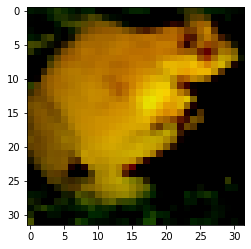

In [44]:
plt.imshow(xs[-1][0].permute(1, 2, 0))

In [ ]:
torch.clamp(xs[-1][0], 0.0, 1.0)

In [33]:
torch.clamp(xs[-1][0], 0.0, 1.0)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0011],
         [0.0027, 0.0032, 0.0042,  ..., 0.0082, 0.0080, 0.0090],
         [0.0000, 0.0000, 0.0000,  ..., 0.0013, 0.0009, 0.0033],
         ...,
         [0.0005, 0.0007, 0.0011,  ..., 0.0036, 0.0039, 0.0059],
         [0.0038, 0.0042, 0.0046,  ..., 0.0075, 0.0069, 0.0076],
         [0.0000, 0.0000, 0.0000,  ..., 0.0006, 0.0007, 0.0021]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0016, 0.0003,  ..., 0.0025, 0.0023, 0.0031],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [ ]:
plt.imshow(img[].permute(1, 2, 0))

In [4]:
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=2e-5, momentum=0.9)
optimizer.load_state_dict(states[2])
epochs = 1

for epoch in range(epochs):
    for batch,label in trainloader:
        def closure():
            loss = model(batch)
            loss.backward()
            return loss
        batch = batch.cuda()
        loss = model(batch)
        loss.backward()
        optimizer.step(closure)
        optimizer.zero_grad()
    
    #img = model.reconstruct_img(batch)
    #plt.imshow(img.permute(1, 2, 0))
    #plt.savefig('img.png')

    #print(f'{epoch}: {loss.item()}')
    
#torch.save(model, 'net.pkl')
    

In [5]:
#img.shape

In [6]:
#plt.imshow(img.permute(1, 2, 0))

In [7]:
loss

tensor(0.1798, device='cuda:0', grad_fn=<MeanBackward0>)